In [9]:
from db import execute_query
import numpy as np
from collections import defaultdict

In [10]:
"""Create the calibration/test splits"""

from sklearn.model_selection import train_test_split

query = f"""
select audio_id, background_modifier_id, audio_info_id
from audio_data 
"""

class Audio:
    def __init__(self, row):
        self.audio_id = row[0]
        self.background_modifier = row[1]
        self.info_id = row[2]

data = execute_query(query)
audio_ids = np.array([Audio(d) for d in data])
background_modifier_ids = np.array([d[1] for d in data])
audio_info_ids = np.array([d[2] for d in data])

labels = np.array(list(zip(background_modifier_ids, audio_info_ids)))
audio_train, audio_test, _, _ = train_test_split(audio_ids, labels, test_size=0.2, stratify=labels, random_state=42)

calibration_ids = [audio.audio_id for audio in audio_train]
calibration_features = [audio.background_modifier for audio in audio_train]

lst = [audio for audio in audio_test if audio.background_modifier == 2]
validation_ids = [audio.audio_id for audio in lst]
validation_features = [audio.background_modifier for audio in lst]

In [ ]:
def count(lst):
    m = defaultdict(int)
    for i in lst:
        m[i.background_modifier] += 1
        
    return m

def count1(lst):
    m = defaultdict(int)
    for i in lst:
        m[i.info_id] += 1
        
    return m

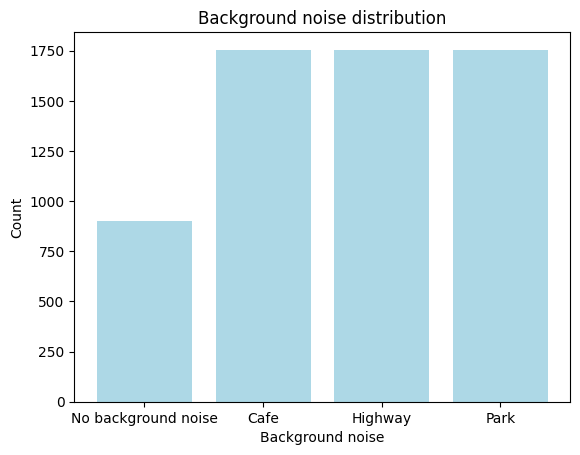

In [106]:
import matplotlib.pyplot as plt

# Sample dictionary data
data = count(audio_train)

# Extract keys and values from the dictionary
keys = ["No background noise", "Cafe", "Highway", "Park"]
values = [data[k] for k in sorted(data.keys())]

# Plotting the histogram
plt.bar(keys, values, color='lightblue')

# Adding labels and title
plt.xlabel('Background noise')
plt.ylabel('Count')
plt.title('Background noise distribution')

# Displaying the plot
plt.show()

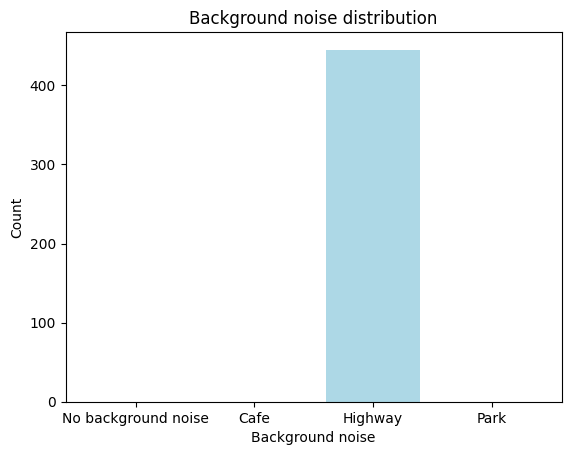

In [108]:
import matplotlib.pyplot as plt

# Sample dictionary data
data = count(lst)

# Extract keys and values from the dictionary
keys = ["No background noise", "Cafe", "Highway", "Park"]
values = [0, 0, 445, 0]

# Plotting the histogram
plt.bar(keys, values, color='lightblue')

# Adding labels and title
plt.xlabel('Background noise')
plt.ylabel('Count')
plt.title('Background noise distribution')

# Displaying the plot
plt.show()

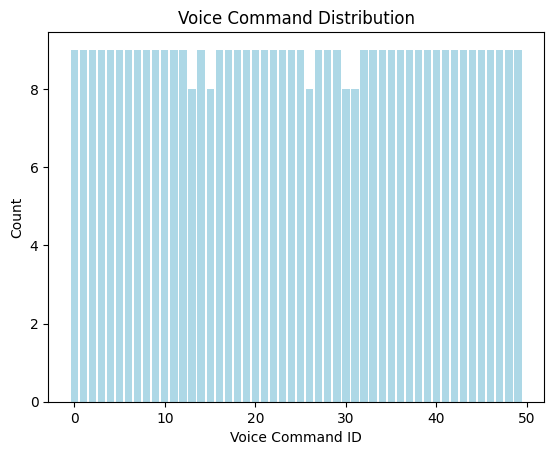

In [104]:
import matplotlib.pyplot as plt

# Sample dictionary data
data = count1(lst)

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Plotting the histogram
plt.bar(keys, values, color='lightblue')

# Adding labels and title
plt.xlabel('Voice Command ID')
plt.ylabel('Count')
plt.title('Voice Command Distribution')

# Displaying the plot
plt.show()

In [11]:
"""Construct the datasets for Conformal Risk Control"""

def create_mapping(data):
    mapping = {}
    idx = 0
    for item in data:
        audio_id = item[0]
        if audio_id not in mapping:
            mapping[audio_id] = idx
            idx += 1
    return mapping

n = len(calibration_ids)
calibration_predictions = [[] for _ in range(n)]
calibration_confidence_scores = [[] for _ in range(n)]
calibration_word_error_rates = [[] for _ in range(n)]
calibration_audio_info_ids = [[] for _ in range(n)]
c_background_modifier_ids = [[] for _ in range(n)]

query = f"""
select Audio_ID, Prediction, Confidence_Score, Word_Error_Rate, Audio_Info_ID, Background_Modifier_ID
from audio_data 
natural join audio_predictions
where audio_id in {tuple(calibration_ids)}
"""
rows = execute_query(query)
mapping = create_mapping(rows)

for row in rows:
    idx = mapping[row[0]]
    calibration_predictions[idx].append(row[1])
    calibration_confidence_scores[idx].append(row[2])
    calibration_word_error_rates[idx].append(row[3])
    calibration_audio_info_ids[idx].append(row[4])
    c_background_modifier_ids[idx].append(row[5])
        
n = len(validation_ids)
validation_predictions = [[] for _ in range(n)]
validation_confidence_scores = [[] for _ in range(n)]
validation_word_error_rates = [[] for _ in range(n)]
validation_audio_info_ids = [[] for _ in range(n)]
v_background_modifier_ids = [[] for _ in range(n)]

query = f"""
select Audio_ID, Prediction, Confidence_Score, Word_Error_Rate, Audio_Info_ID, Background_Modifier_ID
from audio_data 
natural join audio_predictions
where audio_id in {tuple(validation_ids)}
"""
rows = execute_query(query)
mapping = create_mapping(rows)

for row in rows:
    idx = mapping[row[0]]
    validation_predictions[idx].append(row[1])
    validation_confidence_scores[idx].append(row[2])
    validation_word_error_rates[idx].append(row[3])
    validation_audio_info_ids[idx].append(row[4])
    v_background_modifier_ids[idx].append(row[5])
    
def flat(input_list):
    flattened_list = []
    for sublist in input_list:
        if isinstance(sublist, list):
            if sublist:  # Check if the sublist is not empty
                flattened_list.append(sublist[0])
        else:
            flattened_list.append(sublist)
    return flattened_list
    
calibration_features = flat(c_background_modifier_ids)
validation_features = flat(v_background_modifier_ids)

In [12]:
"""Code to compute the weight for each calibration data point"""

from sklearn.ensemble import RandomForestClassifier

def compute_weight_schedule(calibration_features, validation_features):
    X, y = calibration_features + validation_features, [0] * len(calibration_features) + [1] * len(validation_features)
    X, y = np.array(X).reshape(-1, 1), np.array(y)

    binary_classifier = RandomForestClassifier()
    binary_classifier.fit(X, y)
    
    weight_fn = {}
    feature_set = set(calibration_features) | set(validation_features)
    for feature in feature_set:
        probabilities = binary_classifier.predict_proba([[feature]])[0]
        print(feature, probabilities)
        weight_fn[feature] = probabilities[1] / (1 - probabilities[1])

    weight_schedule = [weight_fn[feature] for feature in calibration_features]
    return weight_schedule, weight_fn, binary_classifier

In [13]:
"""Uncomment block to use weighted CRC for calibration"""

weights, weight_fn, classifier = compute_weight_schedule(calibration_features, validation_features)

0 [1. 0.]
1 [1. 0.]
2 [0.79657676 0.20342324]
3 [1. 0.]


In [93]:
"""Uncomment this block to use unweighted CRC for calibration"""

# weights = np.array([1] * len(calibration_features))

# feature_set = set(calibration_features) | set(validation_features)
# weight_fn = {}
# for feature in feature_set:
#     weight_fn[feature] = 1

# classifier = None

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
"""Conformal prediction parameters"""

B = 1
alpha = 0.75
threshold = 0.4  # target word error rate

In [17]:
"""Code for Conformal Risk Control"""

import functools
import numpy as np
from scipy.optimize import brentq

def cumsum_2d_list(lst):
    result = []
    for row in lst:
        cum_sum_row = []
        cum_sum = 0
        for num in row:
            cum_sum += num
            cum_sum_row.append(cum_sum)
        result.append(cum_sum_row)
    return result

def find_first_ge_index(cumsum_list, lam):
    for row_idx, value in enumerate(cumsum_list):
        if value >= lam:
            return row_idx
    return len(cumsum_list) - 1

def all_greater_or_equal(w, wer_target):
    for element in w:
        if element < wer_target:
            return 0
    return 1

def c_lam(lam, smx):
    """Compute prediction set indexes using lambda"""
#     prefix_sums = np.cumsum(smx, axis=1)
    prefix_sums = cumsum_2d_list(smx)
    threshold_indexes = [None for _ in range(len(prefix_sums))]
    for idx, row in enumerate(prefix_sums):
        threshold_idx = find_first_ge_index(row, lam)
        threshold_indexes[idx] = threshold_idx if row[threshold_idx] >= lam else len(row) - 1
    return threshold_indexes

def loss(wers, wer_target):
    """Compute array of losses"""
    return np.array([all_greater_or_equal(w, wer_target) for w in wers])

def losses(lam, smx, wers, wer_target, debug=False):
    """Compute array of losses given Lambda, also compute weight schedule"""
    idxs = c_lam(lam, smx)
    prediction_wers = []
    for idx, threshold_idx in enumerate(idxs):
        prediction_wers.append(wers[idx][:threshold_idx+1])
        
    if debug:
        total_length = 0
        for prediction_wer in prediction_wers:
            total_length += len(prediction_wer)
        print("Mean set size", total_length / len(prediction_wers))

    return loss(prediction_wers, wer_target)

def conformal_risk_control(lam, smx, wers, wer_target, weight_schedule, test_feature_weight=None):
    """This is where conformal risk control happens"""
    n = len(smx)
    loss_values = losses(lam, smx, wers, wer_target)
    
    weighted_sum = 0
    for idx, loss in enumerate(loss_values):
        weighted_sum += weight_schedule[idx] * loss
        
    if test_feature_weight is None:
        return weighted_sum / sum(weight_schedule) - ((n+1)/n*alpha - 1/(n+1))
    
    return (weighted_sum + test_feature_weight * B) / (sum(weight_schedule) + test_feature_weight) - ((n+1)/n*alpha - 1/(n+1))

def compute_lamhat(
        confidence_scores, 
        word_error_rates, 
        wer_target, 
        weight_schedule,
        test_feature_weight=None):
    """Search for value of lambda that controls the WER"""
    crc_partial = functools.partial(
        conformal_risk_control, smx=confidence_scores, wers=word_error_rates, 
        wer_target=wer_target, weight_schedule=weight_schedule,
        test_feature_weight=test_feature_weight)
    try:
        return brentq(crc_partial, 0, 1)
    except ValueError as e:
        if crc_partial(0) > 0:
            return 1
        else:
            return 0

Calibration data: Min coverage = 0.5313594396688952, max coverage = 0.6790830945558739)
Weighted Calibration Data: min coverage = 0.2009132420091324, max coverage = 0.34360730593607314)
Validation Data: min coverage = 0.1919642857142857, max coverage = 0.3214285714285714)


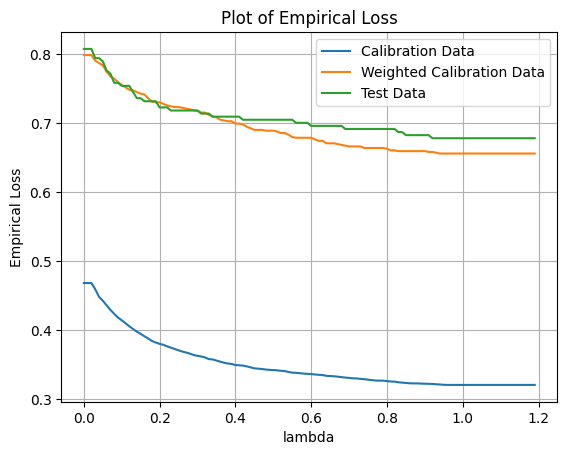

In [21]:
"""Visualise Empirical loss curves"""

import matplotlib.pyplot as plt

def crc_util(lam, smx, wers, wer_target, weight_schedule):
    """Utility function to visualise empirical loss"""
    loss_values = losses(lam, smx, wers, wer_target)
    
    weighted_sum = 0
    for idx, loss in enumerate(loss_values):
        weighted_sum += weight_schedule[idx] * loss

    return weighted_sum / sum(weight_schedule)


x_values = np.arange(0, 1.2, 0.01)

# Define the first set of data
smx_calib = calibration_confidence_scores
wers_calib = calibration_word_error_rates

crc_partial_calib_1 = functools.partial(
    crc_util, 
    smx=smx_calib, 
    wers=wers_calib, 
    wer_target=threshold, 
    weight_schedule=[1] * len(calibration_ids))

print(f"Calibration data: Min coverage = {1-crc_partial_calib_1(0)}, max coverage = {1-crc_partial_calib_1(1)})")

y_values_1 = [crc_partial_calib_1(x) for x in x_values]
plt.plot(x_values, y_values_1, label='Calibration Data')


crc_partial_calib_2 = functools.partial(
    crc_util, smx=smx_calib, wers=wers_calib, 
    wer_target=threshold, weight_schedule=weights)

print(f"Weighted Calibration Data: min coverage = {1-crc_partial_calib_2(0)}, max coverage = {1-crc_partial_calib_2(1)})")

y_values_calib_2 = [crc_partial_calib_2(x) for x in x_values]
plt.plot(x_values, y_values_calib_2, label='Weighted Calibration Data')


smx_test= validation_confidence_scores
wers_test = validation_word_error_rates

crc_partial_test = functools.partial(
    crc_util, 
    smx=smx_test, 
    wers=wers_test, 
    wer_target=threshold, 
    weight_schedule=[1] * len(validation_ids))

print(f"Validation Data: min coverage = {1-crc_partial_test(0)}, max coverage = {1-crc_partial_test(1)})")

y_values_test = [crc_partial_test(x) for x in x_values]
plt.plot(x_values, y_values_test, label='Test Data')


plt.xlabel('lambda')
plt.ylabel('Empirical Loss')
plt.title('Plot of Empirical Loss')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
"""Compute lambda hat"""

lamhat = compute_lamhat(calibration_confidence_scores, calibration_word_error_rates, threshold, weights)
lamhat

0.11967222184515898

In [19]:
"""Compute the coverage and mean set size for calibration set"""

ls = losses(lamhat, calibration_confidence_scores, calibration_word_error_rates, threshold, debug=True)
print("Coverage: ", 1 - ls.mean())

Mean set size 3.586119070359758
Coverage:  0.5937599490608086


In [20]:
"""Compute the coverage and mean set size for validataion set"""

ls = losses(lamhat, validation_confidence_scores, validation_word_error_rates, threshold, debug=True)
print("Coverage: ", 1 - ls.mean())

Mean set size 4.227678571428571
Coverage:  0.2455357142857143


In [12]:
"""Compute the coverage and mean set size using transductive approach"""

n = len(validation_confidence_scores)
lamhats = np.empty(n)
ls = np.empty(n)
set_sizes = np.empty(n)

for idx in range(n):
    feature = validation_features[idx]
    weight = weight_fn[feature]
    
    vcs = np.array([validation_confidence_scores[idx]])
    vwer = np.array([validation_word_error_rates[idx]])
    
    lamhat = compute_lamhat(
        np.array(calibration_confidence_scores), 
        np.array(calibration_word_error_rates), 
        threshold, 
        weights,
        test_feature_weight=weight
    )
    
    lamhats[idx] = lamhat
    ls[idx] = losses(lamhat, vcs, vwer, threshold)
    set_sizes[idx] = c_lam(lamhat, vcs)[0] + 1
    
print("Coverage: ", 1 - ls.mean())
print("Mean set size: ", set_sizes.mean())

KeyboardInterrupt: 